**PCA and Clustering for Stock Market Pairs Trading Selection**

description
documentation

1. clean data: 
   1. test: 2010-2018
   2. train/validation: 2018-2020

2. 



In [1]:
import os
import glob
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN

'''Importing the data'''

def get_paths(fpath, extension=""):
    '''
    returns dictionary of {stock_name:path_to_csv}
    '''
    all_files = glob.glob(fpath + f"/*{extension}") # get all paths in etf_data 
    return {os.path.basename(v):v for v in all_files}

def get_dataframes(fpath=os.getcwd()+"/etf_data/", start_date="2010-01-01", end_date="2020-01-01"):
    start_dt = dt.datetime.strptime(start_date, "%Y-%m-%d")
    end_dt = dt.datetime.strptime(end_date, "%Y-%m-%d")

    paths = get_paths(fpath)
        
    df_list = []
    for symbol, path in paths.items():
        df = pd.read_csv(path, parse_dates=["Date"])
        if df["Date"].iloc[0] >= start_dt or df["Date"].iloc[-1] <= end_dt: # make sure our time series is in the date range
            continue
        else:
            df = df.set_index("Date", drop=True) # set date column as datetimeindex
            df[symbol] = np.log(df["Close"]/df["Close"].shift(1)) # calculate daily logarithmic return and name the column by symbol
            log_returns = df[symbol]
            log_returns = log_returns[start_dt:end_dt] # filter the datetimeindex to the specified date range 
            log_returns = log_returns.dropna() # drop nans
            df_list.append(log_returns)

    return df_list

df_list = get_dataframes()
print(len(df_list))
print("Example dataframe of logarithimic returns:\n", df_list[0])

741
Example dataframe of logarithimic returns:
 Date
2010-01-04    0.020732
2010-01-05    0.000000
2010-01-06    0.014223
2010-01-07   -0.003824
2010-01-08    0.000383
                ...   
2019-12-24    0.005243
2019-12-26    0.009048
2019-12-27    0.000675
2019-12-30   -0.004060
2019-12-31   -0.008169
Name: DBE, Length: 2516, dtype: float64


In [2]:
'''
1. Concatenate the list of dataframes along columns (axis=1) 
2. Take the transpose, where each date is a column/feature
'''

cat = pd.concat(df_list,axis=1)
cat_T = cat.transpose()
cat_T = cat_T.dropna()

print("Concatenated dataframe along columns:\n", cat.iloc[:5,:5]) 
print("\nTaking the transpose:\n", cat_T.iloc[:5,:5])
print("\nDimension of cat_T:", cat_T.shape)


Concatenated dataframe along columns:
                  DBE       FXD      SCHA      QQQX       IEV
Date                                                        
2010-01-04  0.020732  0.010624  0.021245 -0.020342  0.026869
2010-01-05  0.000000  0.011730  0.002999  0.001406  0.001413
2010-01-06  0.014223  0.003214  0.001282 -0.002813  0.000706
2010-01-07 -0.003824  0.005831  0.007660 -0.003562 -0.003180
2010-01-08  0.000383  0.001912  0.005074  0.004266  0.008457

Taking the transpose:
 Date  2010-01-04  2010-01-05  2010-01-06  2010-01-07  2010-01-08
DBE     0.020732    0.000000    0.014223   -0.003824    0.000383
FXD     0.010624    0.011730    0.003214    0.005831    0.001912
SCHA    0.021245    0.002999    0.001282    0.007660    0.005074
QQQX   -0.020342    0.001406   -0.002813   -0.003562    0.004266
IEV     0.026869    0.001413    0.000706   -0.003180    0.008457

Dimension of cat_T: (474, 2516)


In [3]:
'''
Feature Scaling: 
- Standardisation is better for this dataset: 
    - We have unbounded numerical values
    - One of the common assumptions in quantitative is log-normal distribution of prices, 
    which implies normal distribution of logarithmic returns

- cat_T.values returns a np.array of log returns
- We will standardise these log returns using StandardScaler
'''

norm = StandardScaler().fit_transform(cat_T.values)
norm_symbols = cat_T.index

print("Values before standardisation:\n", cat_T.values[:3])
print("\nValues after standardisation:\n", norm[:3])

Values before standardisation:
 [[ 0.02073221  0.          0.0142228  ...  0.00067545 -0.00405955
  -0.00816887]
 [ 0.01062446  0.01172971  0.00321417 ... -0.00177896 -0.00602748
   0.0020132 ]
 [ 0.02124511  0.0029985   0.00128233 ... -0.0044658  -0.0025803
   0.00203763]]

Values after standardisation:
 [[ 0.25145554 -0.32772382  1.15990136 ...  0.16261297 -0.21058866
  -1.73332526]
 [-0.20927245  0.8651923   0.01470644 ... -0.29815159 -0.53848417
  -0.01038369]
 [ 0.27483425 -0.0227748  -0.18625796 ... -0.80254957  0.03588297
  -0.00624971]]


In [4]:
'''
Dimensionality Reduction with PCA before we apply any clustering algos: 
'''

def pca(norm, symbols, n):
    pca = PCA(n_components=n)
    components = pca.fit_transform(norm)

    print(f"{n} largest eigenvectors of the covariance matrix:\n{pca.explained_variance_}")
    print(f"Percentage of variance explained by each component:\n{pca.explained_variance_ratio_}")
    print(f"Total percentage variance explained: {round(sum(pca.explained_variance_ratio_),3)}\n")

    pca_df = pd.DataFrame(components, columns=[f"PC{k}" for k in range(1,n+1)],index=symbols)
    return pca_df

pca_df = pca(norm, norm_symbols, n=2)
print(pca_df)

2 largest eigenvectors of the covariance matrix:
[785.91842604 256.29278827]
Percentage of variance explained by each component:
[0.31170921 0.10165027]
Total percentage variance explained: 0.413

            PC1        PC2
DBE   -3.843656  29.527020
FXD   -8.276933 -11.758918
SCHA -12.535630 -10.866144
QQQX  -3.590825  -7.906984
IEV  -10.440779   1.434052
...         ...        ...
VO    -8.689910  -8.331413
PDP   -6.964313 -11.202085
DLN   -2.062662  -5.570176
CSD   -8.663015  -7.376611
EWX   -9.842612   7.181316

[474 rows x 2 columns]


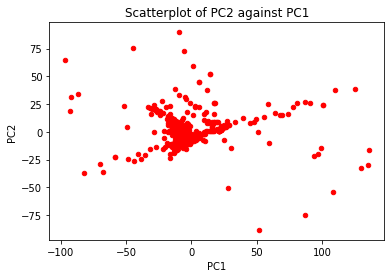

In [5]:
'''
Visualising the PCA in dimension R^2 (PC1 and PC2)
'''

fig, ax = plt.subplots()
pca_df.plot(x="PC1", y="PC2", kind="scatter", 
    title="Scatterplot of PC2 against PC1", ax=ax, color="r")
#for k, _ in pca_df.iterrows():
#    ax.annotate(k,_)
plt.show()


In [6]:
'''
make a pointer to store clustering results
'''



'\nmake a pointer to store clustering results\n'

Number of datapoints = 474


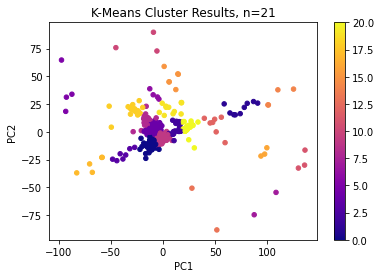

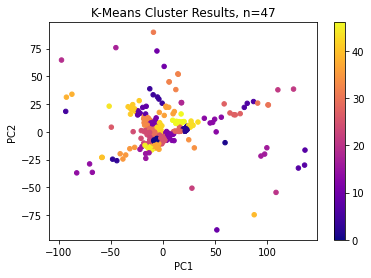

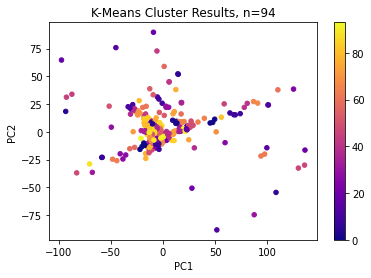

In [10]:
'''
K-Means Clustering
'''

def cluster_kmeans(pca_df, n):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(pca_df)
    results = kmeans.predict(pca_df)

    # plot cluster results
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"K-Means Cluster Results, n={n}", c=results, cmap="plasma", ax=ax)
    plt.show()
    #pca_df["Cluster"] = y_kmeans
    return results


num_datapoints = len(pca_df)
print(f"Number of datapoints = {num_datapoints}")

sqrt_num_datapoints = int(num_datapoints**0.5)
kmeans_results_sqrt_n = cluster_kmeans(pca_df,n=sqrt_num_datapoints)

_10_percent_datapoints = int(0.1*num_datapoints)
kmeans_results_10_n = cluster_kmeans(pca_df,n=_10_percent_datapoints)

_20_percent_datapoints = int(0.2*num_datapoints)
kmeans_results_20_n = cluster_kmeans(pca_df,n=_20_percent_datapoints)


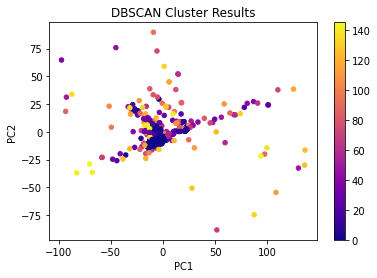

In [8]:
'''
DBSCAN Clustering:
'''

def cluster_dbscan(pca_df):
    dbscan = DBSCAN(eps=1.5, min_samples=0)
    #dbscan.fit(pca_df)
    results = dbscan.fit_predict(pca_df)
    
    fig, ax = plt.subplots()
    pca_df.plot(x="PC1", y="PC2", kind="scatter", 
        title=f"DBSCAN Cluster Results", c=results, cmap="plasma", ax=ax)
    plt.show()

    return results

dbscan_results = cluster_dbscan(pca_df)



In [9]:
'''

'''

'\n\n'

## **What is k-Means Clustering?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/>
<br/> 
* **How does k-Means work?**
     * it is an analytical technique that, for a chosen value of k, identifies k clusters of objects based on the objects’ proximity to the center of the k groups.
     * The center is determined as the arithmetic average (mean) of each cluster’s n-dimensional vector of attributes. 
<br/> 
<br/> 
* **Steps** involved
     1. a k-value is chosen (this determines the number of clusters)
     2. k data points are chosen as the centroids
     3. other data points are assigned/grouped (labeled) to respective centroids (based on whichever centroid they are the closest to)
     <br/> 
     <br/> 
     *for a given data-set of M data points, with p feature variables/attributes such that the *i*-th data point has the coordinates of ($x1_i$,$x2_i$,...$xp_i$)*, 
     <br/> 
     <br/> 
     *for the *Dc*-th centroid chosen, with the coordinates ($x1_{Dc}$,$x2_{Dc}$,...$xp_{Dc}$), the euclidean distance between any given *i*-th data point, where $i \in 1,2,...,M$, and any given *d*-th centroid, where $c \in 1,2,...,k$ is given by*:
     <br/> 
     <br/> 
     $\sqrt{\sum_{j=1}^p (xj_i-xj_{Dc})^2}$
     <br/> 
     <br/> 
     4. after all the data points have been assigned/grouped(labeled), in each cluster, a new centroid coordinate is generated. this is the calculated using the mean of all the coordinates within that particular cluster.
     <br/> 
     *the new centroid for a cluster with z points is given by:*
     <br/> 
     <br/> 
     $(\frac{1}{m} \sum_{i=1}^z x1_i,\frac{1}{m} \sum_{i=1}^z x2_i,...,\frac{1}{m} \sum_{i=1}^z xp_i)$
     <br/> 
     <br/> 
     5. steps 3 and 4 are then repeated till convergence *(this can be done either through setting a limit on the number of recursions or by repeating until the coordinates centroids only change by a small amount (0.01), or until the data points stay within the same cluster for a few repetitions)*
<br/> 
<br/> 
* More pointers
     1. the k-value can be chosen via a variety of techniques, one way is through Within Sum of Squares (WSS).
     2. for each centroid, the sum of squared distances from each of the points within the cluster is calculated  
     3. these values are then summed up together and plotted onto a graph
     <br/> 
     <br/> 
     *for a data set with M points and p feature variables/attributes, the WSS is calculated via:*   
     <br/> 
     $\sum_{i=1}^M \sum_{j=1}^p (xj_i-xj_{Dc})^2$
     <br/>
     <br/>
     *given that the *D*-th centroid has the coordinates ($x1_{Dc}$,$x2_{Dc}$,...$xp_{Dc}$)*  



## **What is PCA?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/>
<br/> 
* **How does PCA work?**
     * it a dimensionality-reduction method that is used to  reduce dimensionality of large data sets by simplifying data, reducing noise and transforming them into smaller ones (but still containing information in the large set)
     * it can be used prior to k-Means so that computation cost is decreased
<br/> 
<br/> 
* Steps involved
     1. calculate mean for every dimension of the dataset
     2. calculate the covariance matrix of the entire dataset
     <br/>
     <br/>
     *for a data set with M feature variables/attributes with $n$ dimensions, using PCA, the data would be reduced from $n$ dimensions to $k$ dimensions, where $n<k$. covariance is calculated by:*
     <br/>
     <br/>
     $cov(X,Y) = \frac{1}{M-1}\sum_{i=1}^M (X_i - \overline{X})(Y_i - \overline{Y})$
     <br/>
     <br/>
     *in this case though, since it is forming a covariance matrix, the covariance matrix, S would be given by:*
     <br/>
     <br/>
     $S = \frac{1}{M}\sum_{i=1}^M (X_i)(X_i)^T$
     <br/>
     <br/>
     3. compute the eigenvectors and the corresponding eigenvalues
     <br/>
     <br/>
     $S = \frac{1}{M}\sum_{i=1}^M (X_i)(X_i)^T$
     <br/>
     <br/>
     4. sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a *d x k* dimensional matrix W
     5. using this matrix, transform the samples onto the new subspace

## **What is DBScans?**


* It is an **Unsupervised Learning** Technique
     * it is the task of discovering hidden structures of unlabeled data
     * this is done through clustering, an exploratory technique
<br/>
<br/> 
* **How does PCA work?**
     * it a dimensionality-reduction method that is used to  reduce dimensionality of large data sets by simplifying data, reducing noise and transforming them into smaller ones (but still containing information in the large set)
     * it can be used prior to k-Means so that computation cost is decreased
<br/> 
<br/> 
* Steps involved
     1. calculate mean for every dimension of the dataset
     2. calculate the covariance matrix of the entire dataset
     <br/>
     <br/>
     *for a data set with M feature variables/attributes with $n$ dimensions, using PCA, the data would be reduced from $n$ dimensions to $k$ dimensions, where $n<k$. covariance is calculated by:*
     <br/>
     <br/>
     $cov(X,Y) = \frac{1}{M-1}\sum_{i=1}^M (X_i - \overline{X})(Y_i - \overline{Y})$
     <br/>
     <br/>
     *in this case though, since it is forming a covariance matrix, the covariance matrix, S would be given by:*
     <br/>
     <br/>
     $S = \frac{1}{M}\sum_{i=1}^M (X_i)(X_i)^T$
     <br/>
     <br/>
     3. compute the eigenvectors and the corresponding eigenvalues
     <br/>
     <br/>
     $S = \frac{1}{M}\sum_{i=1}^M (X_i)(X_i)^T$
     <br/>
     <br/>
     4. sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a *d x k* dimensional matrix W
     5. using this matrix, transform the samples onto the new subspace